In [1]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense # type: ignore
from tensorflow.keras.applications.vgg19 import VGG19 # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy # type: ignore
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping # type: ignore # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # type: ignore
from tensorflow.keras.preprocessing.image import img_to_array # type: ignore
from tensorflow.keras.preprocessing.image import load_img # type: ignore




from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from tqdm import tqdm

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [2]:
import os
import pandas as pd

MildDemented_dir = r'MildDemented'
ModerateDemented_dir = r'ModerateDemented'
NonDemented_dir = r'NonDemented'
VeryMildDemented_dir = r'VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                     filepaths         labels
0    MildDemented\mildDem1.jpg  Mild Demented
1   MildDemented\mildDem10.jpg  Mild Demented
2  MildDemented\mildDem100.jpg  Mild Demented
3  MildDemented\mildDem101.jpg  Mild Demented
4  MildDemented\mildDem102.jpg  Mild Demented
labels
Non Demented         1600
Very MildDemented    1128
Mild Demented         448
Moderate Demented      32
Name: count, dtype: int64


In [3]:
Alzheimer_df.shape

(3208, 2)

In [4]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [5]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(2566, 2)
(963, 2)
(642, 2)
(2245, 2)


In [6]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 2566 validated image filenames belonging to 4 classes.
Found 963 validated image filenames belonging to 4 classes.
Found 642 validated image filenames belonging to 4 classes.


In [7]:
classes=list(train.class_indices.keys())
print (classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


In [8]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

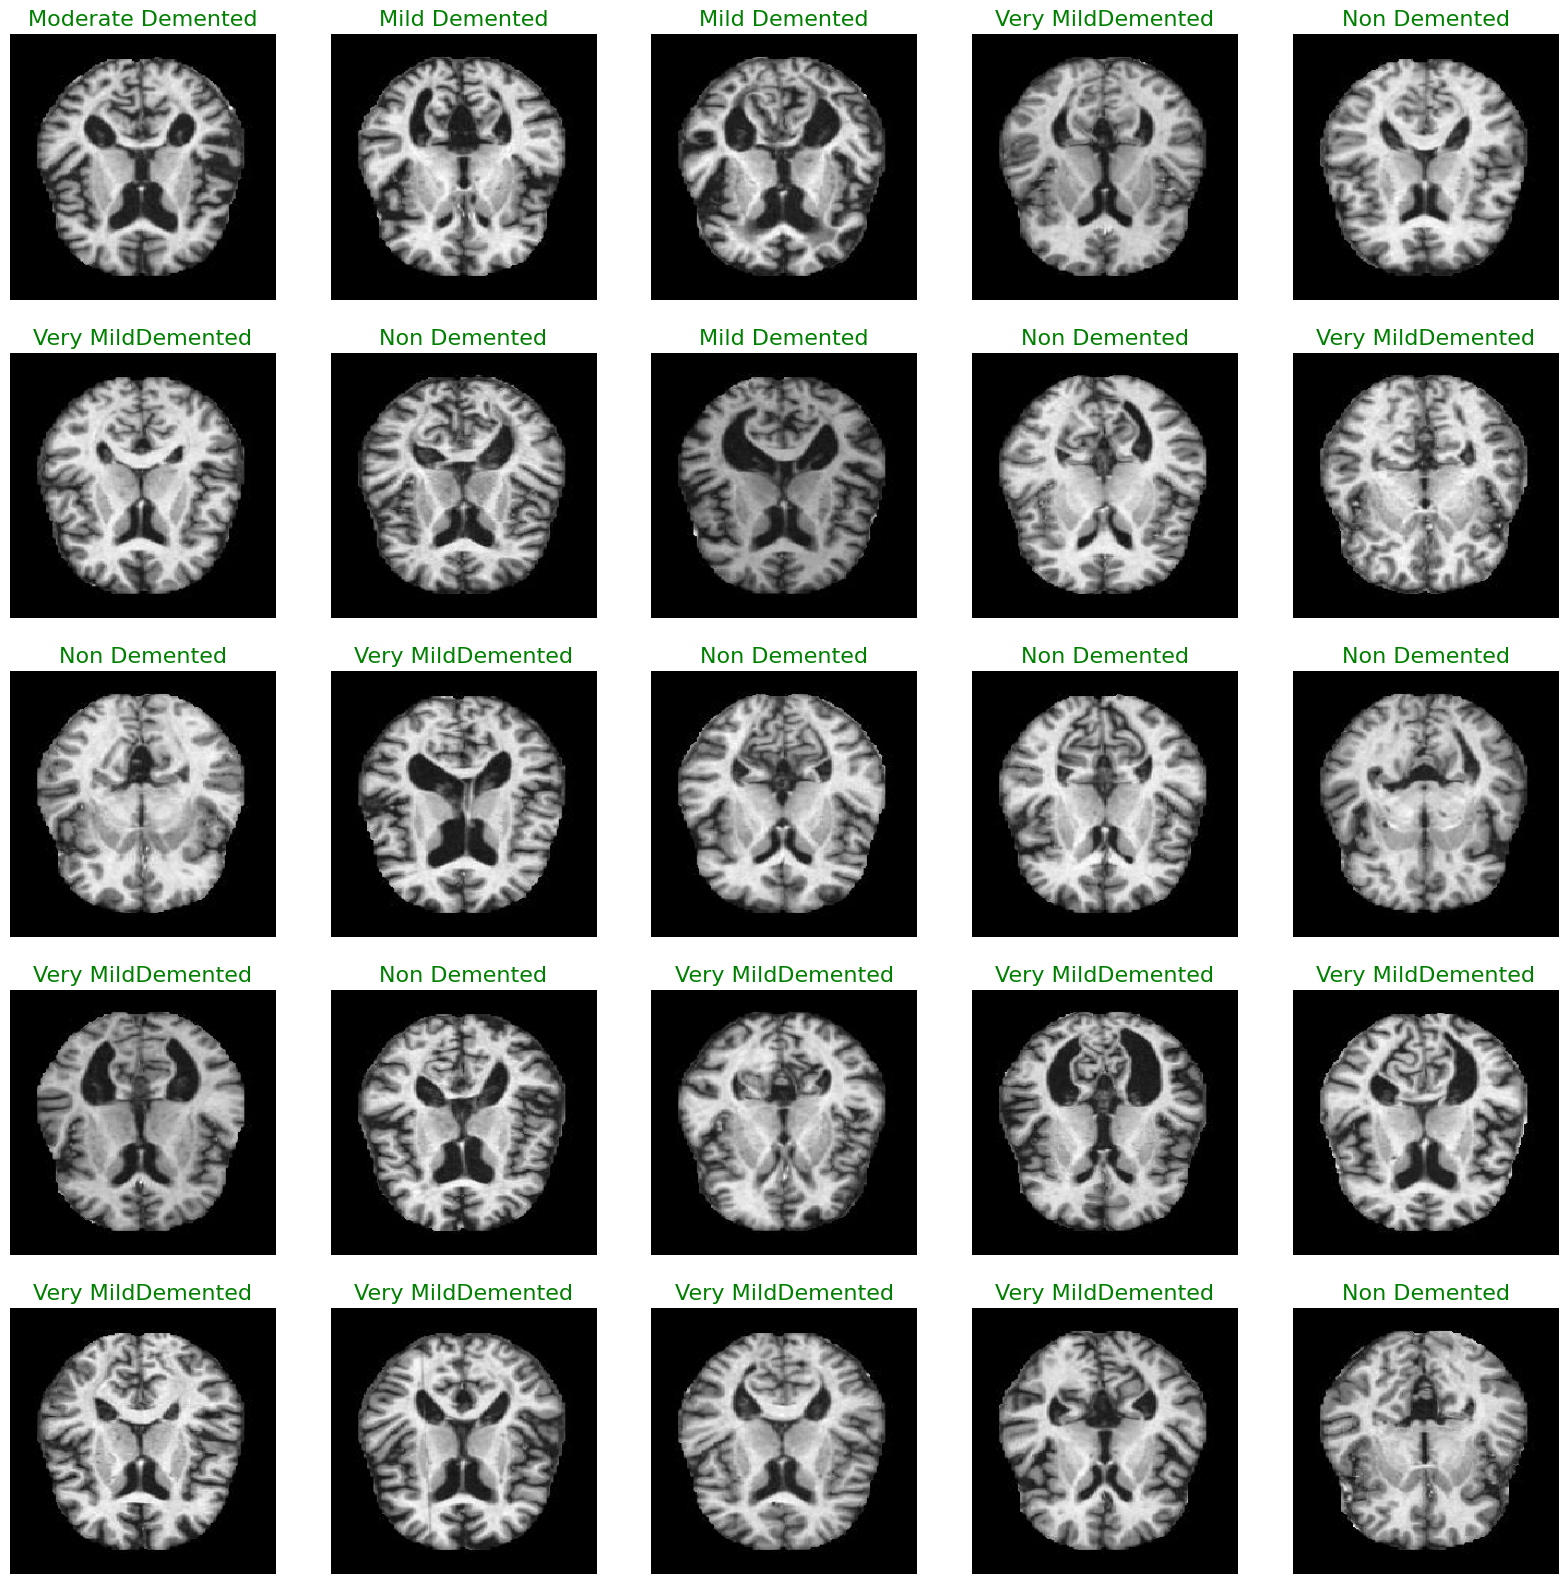

In [9]:
show_knee_images(train)

In [10]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3, 3)),
    
    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 128)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 256)    │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 6, 6, 512)      │         2,04

 Total params: 15,611,524 (59.55 MB)

 Trainable params: 15,605,124 (59.53 MB)

 Non-trainable params: 6,400 (25.00 KB)

In [11]:
num_classes = 4
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = AveragePooling2D((7, 7), name='avg_pool')(x)
x = Flatten()(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



def extract_features(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    features = model.predict(img_array)
    return features.flatten()



filepaths = []

labels = []


for i, label_dir in enumerate(dict_list):

    flist = os.listdir(label_dir)

    for img_file in tqdm(flist, desc=f'Processing {class_labels[i]}'):

        img_path = os.path.join(label_dir, img_file)

        features = extract_features(img_path)

        filepaths.append(img_path)

        labels.append(i)


X = np.array([extract_features(img_path) for img_path in filepaths])
y = np.array(labels)
y = pd.get_dummies(pd.Series(labels)).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)



predictions = rf_classifier.predict(X_test)
print(classification_report(y_test, predictions))
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

history = model.fit(X_train, y_train, epochs=22, validation_data=(X_test, y_test), validation_freq=1)

Processing Mild Demented:   0%|          | 0/448 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


Processing Mild Demented:   0%|          | 1/448 [00:00<02:25,  3.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:   0%|          | 2/448 [00:00<01:43,  4.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Mild Demented:   1%|          | 3/448 [00:00<01:27,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Mild Demented:   1%|          | 4/448 [00:00<01:20,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Mild Demented:   1%|          | 5/448 [00:00<01:15,  5.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:   1%|▏         | 6/448 [00:01<01:15,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:   2%|▏         | 7/448 [00:01<01:13,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:   2%|▏         | 8/448 [00:01<01:14,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Mild Demented:   2%|▏         | 9/448 [00:01<01:12,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:   2%|▏         | 10/448 [00:01<01:13,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:   2%|▏         | 11/448 [00:01<01:11,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:   3%|▎         | 12/448 [00:02<01:12,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Mild Demented:   3%|▎         | 13/448 [00:02<01:11,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Mild Demented:   3%|▎         | 14/448 [00:02<01:10,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Mild Demented:   3%|▎         | 15/448 [00:02<01:08,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:   4%|▎         | 16/448 [00:02<01:10,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Mild Demented:   4%|▍         | 17/448 [00:02<01:09,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Mild Demented:   4%|▍         | 18/448 [00:03<01:08,  6.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:   4%|▍         | 19/448 [00:03<01:08,  6.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Mild Demented:   4%|▍         | 20/448 [00:03<01:07,  6.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:   5%|▍         | 21/448 [00:03<01:07,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Mild Demented:   5%|▍         | 22/448 [00:03<01:11,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:   5%|▌         | 23/448 [00:03<01:10,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:   5%|▌         | 24/448 [00:04<01:10,  6.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:   6%|▌         | 25/448 [00:04<01:10,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Mild Demented:   6%|▌         | 26/448 [00:04<01:10,  6.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Mild Demented:   6%|▌         | 27/448 [00:04<01:09,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:   6%|▋         | 28/448 [00:04<01:10,  5.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Mild Demented:   6%|▋         | 29/448 [00:04<01:09,  6.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:   7%|▋         | 30/448 [00:05<01:08,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:   7%|▋         | 31/448 [00:05<01:08,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:   7%|▋         | 32/448 [00:05<01:08,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


Processing Mild Demented:   7%|▋         | 33/448 [00:05<01:11,  5.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:   8%|▊         | 34/448 [00:05<01:13,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Mild Demented:   8%|▊         | 35/448 [00:05<01:10,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:   8%|▊         | 36/448 [00:06<01:10,  5.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Mild Demented:   8%|▊         | 37/448 [00:06<01:12,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Mild Demented:   8%|▊         | 38/448 [00:06<01:08,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Mild Demented:   9%|▊         | 39/448 [00:06<01:06,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:   9%|▉         | 40/448 [00:06<01:06,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Mild Demented:   9%|▉         | 41/448 [00:06<01:03,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Mild Demented:   9%|▉         | 42/448 [00:07<01:03,  6.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Mild Demented:  10%|▉         | 43/448 [00:07<01:03,  6.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Mild Demented:  10%|▉         | 44/448 [00:07<01:03,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


Processing Mild Demented:  10%|█         | 45/448 [00:07<01:01,  6.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:  10%|█         | 46/448 [00:07<01:02,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Mild Demented:  10%|█         | 47/448 [00:07<01:00,  6.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Mild Demented:  11%|█         | 48/448 [00:07<00:59,  6.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Mild Demented:  11%|█         | 49/448 [00:08<00:59,  6.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Mild Demented:  11%|█         | 50/448 [00:08<01:00,  6.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:  11%|█▏        | 51/448 [00:08<01:02,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Mild Demented:  12%|█▏        | 52/448 [00:08<01:00,  6.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Mild Demented:  12%|█▏        | 53/448 [00:08<01:00,  6.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Mild Demented:  12%|█▏        | 54/448 [00:08<00:59,  6.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Mild Demented:  12%|█▏        | 55/448 [00:09<00:58,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Mild Demented:  12%|█▎        | 56/448 [00:09<00:57,  6.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Mild Demented:  13%|█▎        | 57/448 [00:09<00:57,  6.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


Processing Mild Demented:  13%|█▎        | 58/448 [00:09<00:56,  6.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


Processing Mild Demented:  13%|█▎        | 59/448 [00:09<00:56,  6.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Mild Demented:  13%|█▎        | 60/448 [00:09<00:56,  6.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  14%|█▎        | 61/448 [00:09<00:59,  6.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Mild Demented:  14%|█▍        | 62/448 [00:10<00:59,  6.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  14%|█▍        | 63/448 [00:10<01:01,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  14%|█▍        | 64/448 [00:10<01:02,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  15%|█▍        | 65/448 [00:10<01:05,  5.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Processing Mild Demented:  15%|█▍        | 66/448 [00:10<01:08,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  15%|█▍        | 67/448 [00:10<01:08,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Mild Demented:  15%|█▌        | 68/448 [00:11<01:07,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  15%|█▌        | 69/448 [00:11<01:07,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  16%|█▌        | 70/448 [00:11<01:07,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  16%|█▌        | 71/448 [00:11<01:06,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  16%|█▌        | 72/448 [00:11<01:08,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Mild Demented:  16%|█▋        | 73/448 [00:12<01:10,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  17%|█▋        | 74/448 [00:12<01:11,  5.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  17%|█▋        | 75/448 [00:12<01:10,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  17%|█▋        | 76/448 [00:12<01:09,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  17%|█▋        | 77/448 [00:12<01:09,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  17%|█▋        | 78/448 [00:12<01:07,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Processing Mild Demented:  18%|█▊        | 79/448 [00:13<01:09,  5.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Mild Demented:  18%|█▊        | 80/448 [00:13<01:12,  5.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  18%|█▊        | 81/448 [00:13<01:10,  5.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  18%|█▊        | 82/448 [00:13<01:09,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  19%|█▊        | 83/448 [00:13<01:07,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  19%|█▉        | 84/448 [00:14<01:06,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Mild Demented:  19%|█▉        | 85/448 [00:14<01:06,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  19%|█▉        | 86/448 [00:14<01:06,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  19%|█▉        | 87/448 [00:14<01:05,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  20%|█▉        | 88/448 [00:14<01:04,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  20%|█▉        | 89/448 [00:15<01:04,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  20%|██        | 90/448 [00:15<01:03,  5.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  20%|██        | 91/448 [00:15<01:03,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  21%|██        | 92/448 [00:15<01:03,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  21%|██        | 93/448 [00:15<01:02,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Processing Mild Demented:  21%|██        | 94/448 [00:15<01:05,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  21%|██        | 95/448 [00:16<01:05,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  21%|██▏       | 96/448 [00:16<01:04,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  22%|██▏       | 97/448 [00:16<01:04,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  22%|██▏       | 98/448 [00:16<01:03,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:  22%|██▏       | 99/448 [00:16<01:02,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  22%|██▏       | 100/448 [00:17<01:01,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  23%|██▎       | 101/448 [00:17<01:01,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  23%|██▎       | 102/448 [00:17<01:02,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  23%|██▎       | 103/448 [00:17<01:01,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  23%|██▎       | 104/448 [00:17<01:02,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  23%|██▎       | 105/448 [00:17<01:02,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  24%|██▎       | 106/448 [00:18<01:01,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:  24%|██▍       | 107/448 [00:18<01:01,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Processing Mild Demented:  24%|██▍       | 108/448 [00:18<01:04,  5.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  24%|██▍       | 109/448 [00:18<01:02,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  25%|██▍       | 110/448 [00:18<01:01,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  25%|██▍       | 111/448 [00:19<01:00,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  25%|██▌       | 112/448 [00:19<00:59,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  25%|██▌       | 113/448 [00:19<00:59,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  25%|██▌       | 114/448 [00:19<00:59,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  26%|██▌       | 115/448 [00:19<00:59,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  26%|██▌       | 116/448 [00:19<01:01,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Mild Demented:  26%|██▌       | 117/448 [00:20<01:01,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  26%|██▋       | 118/448 [00:20<01:00,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  27%|██▋       | 119/448 [00:20<01:00,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  27%|██▋       | 120/448 [00:20<01:00,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Mild Demented:  27%|██▋       | 121/448 [00:20<01:01,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  27%|██▋       | 122/448 [00:21<01:00,  5.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  27%|██▋       | 123/448 [00:21<01:00,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  28%|██▊       | 124/448 [00:21<00:59,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  28%|██▊       | 125/448 [00:21<00:58,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  28%|██▊       | 126/448 [00:21<00:57,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:  28%|██▊       | 127/448 [00:21<00:57,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  29%|██▊       | 128/448 [00:22<00:57,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  29%|██▉       | 129/448 [00:22<00:56,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Mild Demented:  29%|██▉       | 130/448 [00:22<00:57,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  29%|██▉       | 131/448 [00:22<00:57,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  29%|██▉       | 132/448 [00:22<00:56,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  30%|██▉       | 133/448 [00:23<00:56,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Mild Demented:  30%|██▉       | 134/448 [00:23<00:58,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  30%|███       | 135/448 [00:23<00:57,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:  30%|███       | 136/448 [00:23<00:56,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  31%|███       | 137/448 [00:23<00:56,  5.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  31%|███       | 138/448 [00:23<00:56,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  31%|███       | 139/448 [00:24<00:56,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  31%|███▏      | 140/448 [00:24<00:55,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Mild Demented:  31%|███▏      | 141/448 [00:24<00:56,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  32%|███▏      | 142/448 [00:24<00:55,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  32%|███▏      | 143/448 [00:24<00:54,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  32%|███▏      | 144/448 [00:25<00:54,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Mild Demented:  32%|███▏      | 145/448 [00:25<00:54,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Mild Demented:  33%|███▎      | 146/448 [00:25<00:56,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  33%|███▎      | 147/448 [00:25<00:55,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  33%|███▎      | 148/448 [00:25<00:54,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  33%|███▎      | 149/448 [00:25<00:54,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  33%|███▎      | 150/448 [00:26<00:54,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  34%|███▎      | 151/448 [00:26<00:53,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  34%|███▍      | 152/448 [00:26<00:54,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Mild Demented:  34%|███▍      | 153/448 [00:26<00:54,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  34%|███▍      | 154/448 [00:26<00:53,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  35%|███▍      | 155/448 [00:27<00:53,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Processing Mild Demented:  35%|███▍      | 156/448 [00:27<00:54,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  35%|███▌      | 157/448 [00:27<00:53,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Mild Demented:  35%|███▌      | 158/448 [00:27<00:55,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  35%|███▌      | 159/448 [00:27<00:54,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  36%|███▌      | 160/448 [00:27<00:53,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Mild Demented:  36%|███▌      | 161/448 [00:28<00:53,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  36%|███▌      | 162/448 [00:28<00:52,  5.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Mild Demented:  36%|███▋      | 163/448 [00:28<00:53,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Mild Demented:  37%|███▋      | 164/448 [00:28<00:53,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Mild Demented:  37%|███▋      | 165/448 [00:28<00:53,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Processing Mild Demented:  37%|███▋      | 166/448 [00:29<00:53,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  37%|███▋      | 167/448 [00:29<00:52,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  38%|███▊      | 168/448 [00:29<00:51,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Mild Demented:  38%|███▊      | 169/448 [00:29<00:50,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Processing Mild Demented:  38%|███▊      | 170/448 [00:29<00:52,  5.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  38%|███▊      | 171/448 [00:30<00:51,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  38%|███▊      | 172/448 [00:30<00:50,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  39%|███▊      | 173/448 [00:30<00:49,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Mild Demented:  39%|███▉      | 174/448 [00:30<00:50,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  39%|███▉      | 175/448 [00:30<00:49,  5.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  39%|███▉      | 176/448 [00:30<00:49,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  40%|███▉      | 177/448 [00:31<00:49,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  40%|███▉      | 178/448 [00:31<00:49,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  40%|███▉      | 179/448 [00:31<00:49,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  40%|████      | 180/448 [00:31<00:48,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  40%|████      | 181/448 [00:31<00:47,  5.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


Processing Mild Demented:  41%|████      | 182/448 [00:32<00:48,  5.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  41%|████      | 183/448 [00:32<00:47,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  41%|████      | 184/448 [00:32<00:47,  5.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Mild Demented:  41%|████▏     | 185/448 [00:32<00:47,  5.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Mild Demented:  42%|████▏     | 186/448 [00:32<00:47,  5.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


Processing Mild Demented:  42%|████▏     | 187/448 [00:32<00:48,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  42%|████▏     | 188/448 [00:33<00:48,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  42%|████▏     | 189/448 [00:33<00:48,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  42%|████▏     | 190/448 [00:33<00:48,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  43%|████▎     | 191/448 [00:33<00:47,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  43%|████▎     | 192/448 [00:33<00:46,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Processing Mild Demented:  43%|████▎     | 193/448 [00:34<00:47,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  43%|████▎     | 194/448 [00:34<00:47,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  44%|████▎     | 195/448 [00:34<00:46,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Mild Demented:  44%|████▍     | 196/448 [00:34<00:46,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


Processing Mild Demented:  44%|████▍     | 197/448 [00:34<00:47,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Mild Demented:  44%|████▍     | 198/448 [00:34<00:47,  5.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Processing Mild Demented:  44%|████▍     | 199/448 [00:35<00:46,  5.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  45%|████▍     | 200/448 [00:35<00:46,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Mild Demented:  45%|████▍     | 201/448 [00:35<00:45,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  45%|████▌     | 202/448 [00:35<00:44,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  45%|████▌     | 203/448 [00:35<00:44,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  46%|████▌     | 204/448 [00:36<00:43,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


Processing Mild Demented:  46%|████▌     | 205/448 [00:36<00:45,  5.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  46%|████▌     | 206/448 [00:36<00:44,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  46%|████▌     | 207/448 [00:36<00:44,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  46%|████▋     | 208/448 [00:36<00:44,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Mild Demented:  47%|████▋     | 209/448 [00:37<00:44,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Mild Demented:  47%|████▋     | 210/448 [00:37<00:44,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  47%|████▋     | 211/448 [00:37<00:44,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  47%|████▋     | 212/448 [00:37<00:43,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  48%|████▊     | 213/448 [00:37<00:43,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  48%|████▊     | 214/448 [00:37<00:42,  5.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Mild Demented:  48%|████▊     | 215/448 [00:38<00:43,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  48%|████▊     | 216/448 [00:38<00:43,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


Processing Mild Demented:  48%|████▊     | 217/448 [00:38<00:44,  5.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  49%|████▊     | 218/448 [00:38<00:43,  5.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  49%|████▉     | 219/448 [00:38<00:42,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  49%|████▉     | 220/448 [00:39<00:40,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:  49%|████▉     | 221/448 [00:39<00:39,  5.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  50%|████▉     | 222/448 [00:39<00:38,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Mild Demented:  50%|████▉     | 223/448 [00:39<00:37,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:  50%|█████     | 224/448 [00:39<00:38,  5.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  50%|█████     | 225/448 [00:39<00:39,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Mild Demented:  50%|█████     | 226/448 [00:40<00:40,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Mild Demented:  51%|█████     | 227/448 [00:40<00:40,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


Processing Mild Demented:  51%|█████     | 228/448 [00:40<00:42,  5.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Mild Demented:  51%|█████     | 229/448 [00:40<00:42,  5.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  51%|█████▏    | 230/448 [00:40<00:41,  5.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


Processing Mild Demented:  52%|█████▏    | 231/448 [00:41<00:39,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:  52%|█████▏    | 232/448 [00:41<00:38,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  52%|█████▏    | 233/448 [00:41<00:38,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  52%|█████▏    | 234/448 [00:41<00:37,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  52%|█████▏    | 235/448 [00:41<00:36,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  53%|█████▎    | 236/448 [00:41<00:36,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Mild Demented:  53%|█████▎    | 237/448 [00:42<00:35,  5.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:  53%|█████▎    | 238/448 [00:42<00:35,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:  53%|█████▎    | 239/448 [00:42<00:34,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Processing Mild Demented:  54%|█████▎    | 240/448 [00:42<00:36,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  54%|█████▍    | 241/448 [00:42<00:36,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  54%|█████▍    | 242/448 [00:42<00:36,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Mild Demented:  54%|█████▍    | 243/448 [00:43<00:35,  5.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Mild Demented:  54%|█████▍    | 244/448 [00:43<00:34,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


Processing Mild Demented:  55%|█████▍    | 245/448 [00:43<00:35,  5.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


Processing Mild Demented:  55%|█████▍    | 246/448 [00:43<00:36,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Mild Demented:  55%|█████▌    | 247/448 [00:43<00:36,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  55%|█████▌    | 248/448 [00:44<00:37,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  56%|█████▌    | 249/448 [00:44<00:36,  5.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  56%|█████▌    | 250/448 [00:44<00:35,  5.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


Processing Mild Demented:  56%|█████▌    | 251/448 [00:44<00:37,  5.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  56%|█████▋    | 252/448 [00:44<00:36,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  56%|█████▋    | 253/448 [00:44<00:36,  5.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  57%|█████▋    | 254/448 [00:45<00:35,  5.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  57%|█████▋    | 255/448 [00:45<00:35,  5.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  57%|█████▋    | 256/448 [00:45<00:34,  5.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  57%|█████▋    | 257/448 [00:45<00:34,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  58%|█████▊    | 258/448 [00:45<00:34,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  58%|█████▊    | 259/448 [00:46<00:33,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  58%|█████▊    | 260/448 [00:46<00:33,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


Processing Mild Demented:  58%|█████▊    | 261/448 [00:46<00:33,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  58%|█████▊    | 262/448 [00:46<00:33,  5.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  59%|█████▊    | 263/448 [00:46<00:32,  5.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


Processing Mild Demented:  59%|█████▉    | 264/448 [00:46<00:34,  5.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  59%|█████▉    | 265/448 [00:47<00:34,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  59%|█████▉    | 266/448 [00:47<00:33,  5.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  60%|█████▉    | 267/448 [00:47<00:33,  5.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  60%|█████▉    | 268/448 [00:47<00:33,  5.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Mild Demented:  60%|██████    | 269/448 [00:47<00:32,  5.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  60%|██████    | 270/448 [00:48<00:32,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:  60%|██████    | 271/448 [00:48<00:30,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  61%|██████    | 272/448 [00:48<00:31,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Mild Demented:  61%|██████    | 273/448 [00:48<00:30,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:  61%|██████    | 274/448 [00:48<00:29,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


Processing Mild Demented:  61%|██████▏   | 275/448 [00:48<00:31,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


Processing Mild Demented:  62%|██████▏   | 276/448 [00:49<00:32,  5.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  62%|██████▏   | 277/448 [00:49<00:31,  5.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


Processing Mild Demented:  62%|██████▏   | 278/448 [00:49<00:31,  5.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  62%|██████▏   | 279/448 [00:49<00:30,  5.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  62%|██████▎   | 280/448 [00:49<00:29,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


Processing Mild Demented:  63%|██████▎   | 281/448 [00:49<00:29,  5.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step


Processing Mild Demented:  63%|██████▎   | 282/448 [00:50<00:29,  5.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Mild Demented:  63%|██████▎   | 283/448 [00:50<00:29,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  63%|██████▎   | 284/448 [00:50<00:28,  5.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Mild Demented:  64%|██████▎   | 285/448 [00:50<00:28,  5.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  64%|██████▍   | 286/448 [00:50<00:27,  5.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Mild Demented:  64%|██████▍   | 287/448 [00:50<00:26,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


Processing Mild Demented:  64%|██████▍   | 288/448 [00:51<00:26,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


Processing Mild Demented:  65%|██████▍   | 289/448 [00:51<00:27,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Mild Demented:  65%|██████▍   | 290/448 [00:51<00:26,  6.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Mild Demented:  65%|██████▍   | 291/448 [00:51<00:25,  6.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


Processing Mild Demented:  65%|██████▌   | 292/448 [00:51<00:25,  6.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:  65%|██████▌   | 293/448 [00:51<00:25,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Mild Demented:  66%|██████▌   | 294/448 [00:52<00:25,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:  66%|██████▌   | 295/448 [00:52<00:24,  6.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


Processing Mild Demented:  66%|██████▌   | 296/448 [00:52<00:25,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


Processing Mild Demented:  66%|██████▋   | 297/448 [00:52<00:24,  6.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


Processing Mild Demented:  67%|██████▋   | 298/448 [00:52<00:24,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Mild Demented:  67%|██████▋   | 299/448 [00:52<00:23,  6.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Processing Mild Demented:  67%|██████▋   | 300/448 [00:53<00:25,  5.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


Processing Mild Demented:  67%|██████▋   | 301/448 [00:53<00:25,  5.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Mild Demented:  67%|██████▋   | 302/448 [00:53<00:25,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


Processing Mild Demented:  68%|██████▊   | 303/448 [00:53<00:25,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:  68%|██████▊   | 304/448 [00:53<00:24,  5.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  68%|██████▊   | 305/448 [00:53<00:24,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


Processing Mild Demented:  68%|██████▊   | 306/448 [00:54<00:23,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Mild Demented:  69%|██████▊   | 307/448 [00:54<00:23,  6.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Mild Demented:  69%|██████▉   | 308/448 [00:54<00:23,  6.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  69%|██████▉   | 309/448 [00:54<00:22,  6.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Mild Demented:  69%|██████▉   | 310/448 [00:54<00:22,  6.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


Processing Mild Demented:  69%|██████▉   | 311/448 [00:54<00:21,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  70%|██████▉   | 312/448 [00:55<00:22,  6.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  70%|██████▉   | 313/448 [00:55<00:22,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  70%|███████   | 314/448 [00:55<00:22,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Mild Demented:  70%|███████   | 315/448 [00:55<00:22,  5.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


Processing Mild Demented:  71%|███████   | 316/448 [00:55<00:21,  6.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


Processing Mild Demented:  71%|███████   | 317/448 [00:55<00:22,  5.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


Processing Mild Demented:  71%|███████   | 318/448 [00:56<00:21,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:  71%|███████   | 319/448 [00:56<00:21,  6.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


Processing Mild Demented:  71%|███████▏  | 320/448 [00:56<00:21,  6.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


Processing Mild Demented:  72%|███████▏  | 321/448 [00:56<00:20,  6.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


Processing Mild Demented:  72%|███████▏  | 322/448 [00:56<00:19,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


Processing Mild Demented:  72%|███████▏  | 323/448 [00:56<00:21,  5.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


Processing Mild Demented:  72%|███████▏  | 324/448 [00:57<00:20,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


Processing Mild Demented:  73%|███████▎  | 325/448 [00:57<00:20,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  73%|███████▎  | 326/448 [00:57<00:20,  5.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


Processing Mild Demented:  73%|███████▎  | 327/448 [00:57<00:20,  6.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


Processing Mild Demented:  73%|███████▎  | 328/448 [00:57<00:20,  5.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


Processing Mild Demented:  73%|███████▎  | 329/448 [00:57<00:20,  5.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Mild Demented:  74%|███████▎  | 330/448 [00:58<00:19,  6.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


Processing Mild Demented:  74%|███████▍  | 331/448 [00:58<00:18,  6.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Mild Demented:  74%|███████▍  | 332/448 [00:58<00:17,  6.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


Processing Mild Demented:  74%|███████▍  | 333/448 [00:58<00:17,  6.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


Processing Mild Demented:  75%|███████▍  | 334/448 [00:58<00:18,  6.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Processing Mild Demented:  75%|███████▍  | 335/448 [00:58<00:19,  5.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


Processing Mild Demented:  75%|███████▌  | 336/448 [00:59<00:19,  5.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


Processing Mild Demented:  75%|███████▌  | 337/448 [00:59<00:19,  5.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


Processing Mild Demented:  75%|███████▌  | 338/448 [00:59<00:19,  5.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


Processing Mild Demented:  76%|███████▌  | 339/448 [00:59<00:19,  5.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


Processing Mild Demented:  76%|███████▌  | 340/448 [00:59<00:18,  5.84it/s]

In [ ]:
history = model.fit(train, epochs=22, validation_data=val, validation_freq=1)

In [ ]:
model.evaluate(test, verbose=1)

In [ ]:
model.save("Osteoporosis_Model_binary.h5")

In [ ]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()